# DeepSom: Clustering Analaysis with Word2Vec
### Notebook 2

#### By TJ Cycyota
##### Thanks to [Jeff Delaney](https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne) for inspiration

### Hypothesis
We can visualize wine clusters using multiple dimensionality-reduction techniques, including Word2Vec and t-SNE.

### Steps:
1. Clean the data
2. Build a corpus
3. Train a Word2Vec Model
4. Visualize t-SNE representationso of the most common words


In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk
nltk.download('stopwords')

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thomas.j.cycyota\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


C:\Users\thomas.j.cycyota\AppData\Local\Continuum\Anaconda2\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
data = pd.read_json('winemag-data.json', dtype={
    'points': np.int32,
    'price': np.float32,
})

In [3]:
pd.set_option('display.max_colwidth', 300)
pd.set_option('display.width', 1000)

data.head(20)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,France,"This Chardonnay-based wine, with 10% Chenin Blanc, opens with aromas of pressed yellow flowers, peach blossom and just-ripe tropical fruit. There's good zip to the bright fruit flavors, finishing fresh and clean. Drink now.",None,87,10.0,Languedoc-Roussillon,Pays d'Oc,None,Lauren Buzzeo,@laurbuzz,Domaine Rives-Blanques 2016 White (Pays d'Oc),White Blend,Domaine Rives-Blanques
1,France,"Wood aromas and spice show strongly in this wine. On the palate, there is a toasty character that gives a bitter edge to the ripe red fruits. That needs to go, so wait to drink this wine from 2019.",Domaine de la Ferté,87,35.0,Burgundy,Givry,None,Roger Voss,@vossroger,Domaines Devillard 2015 Domaine de la Ferté (Givry),Pinot Noir,Domaines Devillard
2,France,"Showcasing the rich vintage, this is a generous fruit-driven wine. With red-berry flavors and plenty of acidity to balance, the wine is soft and juicy. Drink it from 2018.",Le Renard,87,23.0,Burgundy,Bourgogne,None,Roger Voss,@vossroger,Domaines Devillard 2015 Le Renard (Bourgogne),Pinot Noir,Domaines Devillard
3,France,"This large appellation in the Côte Chalonnaise can produce fruity wines like this. With red-berry fruits and light tannins, the wine has spice and crisp edge of acidity that comes from fruit that was just ripe, surprising in the rich 2015 vintage. The wine will be ready to drink from 2018.",Laurent Dufouleur Château Mi-Pont,87,40.0,Burgundy,Mercurey,None,Roger Voss,@vossroger,L. Tramier & Fils 2015 Laurent Dufouleur Château Mi-Pont (Mercurey),Pinot Noir,L. Tramier & Fils
4,France,"This tangy, ripe and fruity wine is crisp with acidity. It's attractively brimming with fruit and ready to drink.",None,87,19.0,Burgundy,Mâcon-Villages,None,Roger Voss,@vossroger,Louis Max 2016 Mâcon-Villages,Chardonnay,Louis Max
5,US,"Crisp apple perfume builds on the palate, suggesting unusually lifted notes of raspberry, strawberry and cherry in this semidry Riesling. It's a plush, slightly rounded white with easy, juicy fruit and a brisk finish.",Semi-Dry,87,15.0,New York,Finger Lakes,Finger Lakes,Anna Lee C. Iijima,None,Highland Cellars 2015 Semi-Dry Riesling (Finger Lakes),Riesling,Highland Cellars
6,US,"The freshness and concentration of the fruit flavors in this full-bodied wine is exceptional. It smells like Concord juice and tastes dark and grapy, forming a simple but appealing personality that's hard to resist.",None,87,25.0,California,Lodi,Central Valley,Jim Gordon,@gordone_cellars,Infidel 2014 Zinfandel (Lodi),Zinfandel,Infidel
7,France,"Crisp apple aromas lead to a spicy, yellow and melon-flavored wine. With its touches of vanilla and warm, ripe character, the wine is full and generous. Drink now.",None,87,18.0,Burgundy,Bourgogne,None,Roger Voss,@vossroger,Domaine Bernard Moreau 2016 Bourgogne,Chardonnay,Domaine Bernard Moreau
8,France,"A crisp, tangy and mineral-driven wine, this is also ripe with generous citrus and apple flavors. The texture is still tight. which will allow it to age. Drink from 2018.",La Belouse,87,20.0,Burgundy,Mâcon-Cruzille,None,Roger Voss,@vossroger,Domaine de l'Echelette 2016 La Belouse (Mâcon-Cruzille),Chardonnay,Domaine de l'Echelette
9,Italy,"Oak-driven spice, camphor and coconut aromas lead the nose of this wine. Tight, bracing and lacking fruit richness, it shows instead roasted coffee bean, toasted oak, dried cherry and vanilla notes. Astringent, grainy tannins leave a raspy finish.",Riserva,87,NaN,Piedmont,Barbaresco,None,Kerin O’Keefe,@kerinokeefe,Sassi San Cristoforo 2012 Riserva (Barbaresco),Nebbiolo,Sassi San Cristoforo


In [4]:
STOP_WORDS = nltk.corpus.stopwords.words()

def clean_sentence(val):
    #Remove chars that are not letters or numbers; downcase; remove stop words
    regex = re.compile('([^\s\w\-\%]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)
            
    sentence = " ".join(sentence)
    return sentence
    
def clean_dataframe(frame, columns):
    "frame is a pandas dataframe; column is an array of column names"
    #Drop NaNs (not needed); apply 'clean_sentence' function to Description
    #frame = frame.dropna(how="any")
    
    for col in columns:
        frame[col] = frame[col].apply(clean_sentence)
    return frame

In [5]:
data_cleaned = data.copy()
data_cleaned = clean_dataframe(data_cleaned, ["description", "title"])


In [9]:
#data_cleaned.head(2)

In [10]:
def build_corpus(data, columns):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in columns:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

In [11]:
corpus = build_corpus(data_cleaned, ["description"])
corpus[0:2]

[[u'chardonnay-based',
  u'wine',
  u'10%',
  u'chenin',
  u'blanc',
  u'opens',
  u'aromas',
  u'pressed',
  u'yellow',
  u'flowers',
  u'peach',
  u'blossom',
  u'just-ripe',
  u'tropical',
  u'fruit',
  u'theres',
  u'good',
  u'zip',
  u'bright',
  u'fruit',
  u'flavors',
  u'finishing',
  u'fresh',
  u'clean',
  u'drink'],
 [u'wood',
  u'aromas',
  u'spice',
  u'show',
  u'strongly',
  u'wine',
  u'palate',
  u'toasty',
  u'character',
  u'gives',
  u'bitter',
  u'edge',
  u'ripe',
  u'red',
  u'fruits',
  u'needs',
  u'go',
  u'wait',
  u'drink',
  u'wine',
  u'2019']]

## Word2Vec Implementation

Using Word2Vec for word embedding. Prepares data for visualization vy converting each text word into a numeric vector of size="size".

In [12]:
w2v = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)
w2v.wv["wine"]

array([-0.174786  ,  0.38333714, -0.77213961, -0.05621782,  0.09990653,
        0.41330197,  0.24989913, -0.23794474, -0.32184082,  0.55329359,
        0.25160968,  0.20686769,  0.39857551,  0.2363912 ,  0.10919964,
        0.31143945, -0.18594171,  0.19781816, -0.23637831, -0.39212832,
        0.1111842 ,  0.21890905,  0.05405272,  0.14507104, -0.0907125 ,
       -0.38208306,  0.27381071,  0.31452361, -0.27264193,  0.01172068,
       -0.24468851,  0.50920618, -0.25368285,  0.11402563,  0.21278729,
       -0.11345093, -0.37761933, -0.34006459, -0.35937318, -0.20942102,
       -0.55568022,  0.14191547,  0.1453955 , -0.08523662, -0.27827406,
        0.12227719,  0.29254094, -0.25051585,  0.01231198, -0.21107294,
        0.49894023,  0.42955056,  0.12534668, -0.05289851, -0.37859353,
       -0.2590667 ,  0.08256005,  0.03591231, -0.41744515,  0.01544096,
       -0.12373867, -0.46932262, -0.0605043 , -0.1583205 , -0.02336002,
        0.27147892, -0.12466212, -0.32815903,  0.59844166,  0.30

## t-SNE Implementation

t-Distributed Stochastic Neighbor Embedding (t-SNE)
t-SNE is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. The goal is to take a set of points in a high-dimensional space and find a representation of those points in a lower-dimensional space, typically the 2D plane. It is based on probability distributions with random walk on neighborhood graphs to find the structure within the data. But since t-SNE complexity is significantly high, usually we'd use other high-dimension reduction techniques before applying t-SNE.


In [13]:
def tsne_plot(model):
    "Creates a t-SNE model; plots it"
    labels = []
    tokens = []
    
    #Get the entire vocab from the Word2Vec model
    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
        
    #Configure and fit sklearn's t-SNE model
    tsne_model = TSNE(init='pca', random_state=1)
    new_values = tsne_model.fit_transform(tokens)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                    xy=(x[i], y[i]),
                    xytext = (5,2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')
    plt.show()
        

C:\Users\thomas.j.cycyota\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


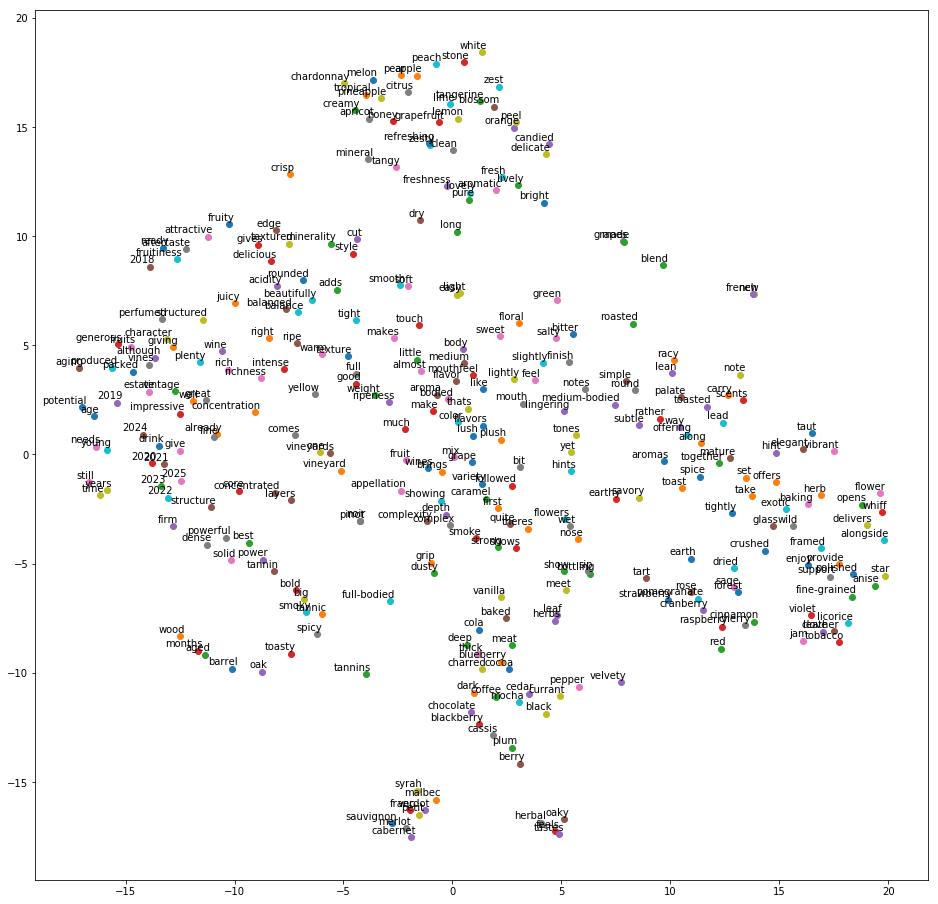

In [14]:
tsne_plot(w2v)